# Определение возраста покупателей

## Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:  
- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы
- контролировать добросовестность кассиров при продаже алкоголя  

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.  

План выполнения проекта:  
- исследовательский анализ входных данных  
- подготовка данных к обучению  
- обучение нейронной сети  
- анализ результатов  

## Исследовательский анализ данных

In [1]:
# Подключение библиотек
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.models import Sequential
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Загрузка датафрейма
labels = pd.read_csv('/datasets/faces/labels.csv')

# Генератор данных
datagen = ImageDataGenerator(rescale=1./255)


train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels.head(100),
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 100 validated image filenames.


In [3]:
# Вывод первых строк
labels.head(100)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
95,000095.jpg,17
96,000096.jpg,53
97,000097.jpg,51
98,000098.jpg,24


In [4]:
#Размер выборки
len(labels)

7591

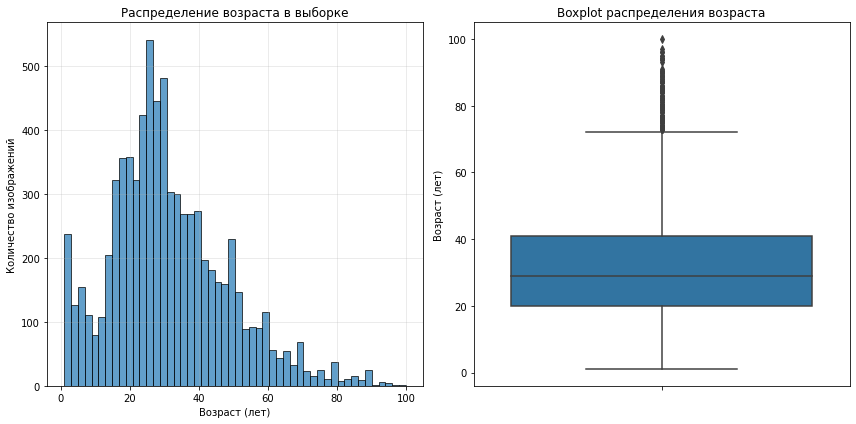

In [5]:
plt.figure(figsize=(12, 6))

# Гистограмма распределения возраста
plt.subplot(1, 2, 1)
plt.hist(labels['real_age'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Распределение возраста в выборке')
plt.xlabel('Возраст (лет)')
plt.ylabel('Количество изображений')
plt.grid(True, alpha=0.3)

# Boxplot для возраста
plt.subplot(1, 2, 2)
sns.boxplot(y=labels['real_age'])
plt.title('Boxplot распределения возраста')
plt.ylabel('Возраст (лет)')

plt.tight_layout()
plt.show()

In [6]:
print(f"Диапазон возрастов: от {labels['real_age'].min()} до {labels['real_age'].max()} лет")
print(f"Средний возраст: {labels['real_age'].mean():.2f} лет")
print(f"Медианный возраст: {labels['real_age'].median()} лет")

Диапазон возрастов: от 1 до 100 лет
Средний возраст: 31.20 лет
Медианный возраст: 29.0 лет


Распределение возрастов неравномерное - больше изображений людей молодого и среднего возраста (от 20 до 40 лет). Средний возраст равен 31 году.

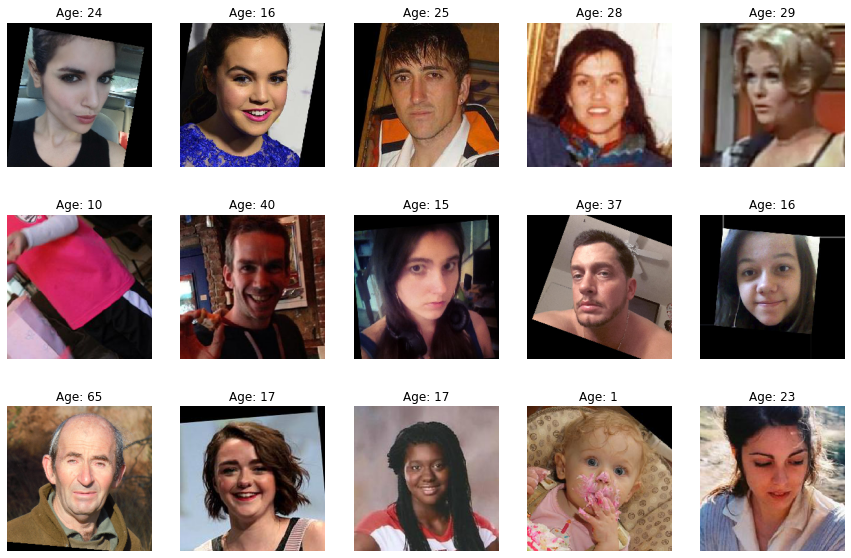

In [7]:
# Выведем на экран 15 первых фотографий
images, ages = next(train_gen_flow)
fig, axes = plt.subplots(3, 5, figsize=(15, 10))
axes = axes.flatten()

for i in range(15):
    axes[i].imshow(images[i])
    axes[i].set_title(f'Age: {ages[i]:.0f}')
    axes[i].axis('off')

In [8]:
# Размерность фотографий
print(f"Размерность одного изображения: {images[0].shape}")

Размерность одного изображения: (224, 224, 3)


В датаете всего 7591 фотография. Диапазон возрастов - от 1 до 100 лет. Средний возраст - 31 год. Медианный возраст - 29 лет. Распределение возрастов неравномерное - больше изображений людей молодого и среднего возраста (от 20 до 40 лет). Для лучшего обучения модели потребуется аугментация изображений тренировочной выборки.

## Обучение модели

**Код в этом разделе запускался в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке.**  

Описание функций:

**load_train(path)**  
Функция загружает обучающую часть датасета и подготавливает данные для обучения модели.  
На вход принимает путь к директории с датасетом.  
Выполняет аугментацию изображений (повороты, сдвиги, отражения, изменение яркости и др.) и нормализацию значений пикселей.  
Возвращает: генератор (DirectoryIterator), который выдаёт мини-батчи изображений и соответствующих меток для обучения модели.  

**load_test(path)**  
Функция загружает тестовую (валидационную) часть датасета.  
На вход принимает путь к директории с датасетом.  
Производит только нормализацию данных без аугментации.  
Возвращает: генератор (DirectoryIterator), который выдаёт мини-батчи изображений и меток для проверки качества модели на валидационных данных.  

**create_model(input_shape=(224, 224, 3))**  
Функция создаёт и компилирует нейронную сеть на базе архитектуры ResNet50V2.  
На вход принимает размер входного изображения (input_shape).  
К предобученному сверточному блоку добавляются полносвязные, нормализующие и регуляризующие слои.  
Возвращает: скомпилированную модель Keras (Sequential), готовую к обучению.  

**train_model(model, train_data, test_data, batch_size=None, epochs=15, steps_per_epoch=None, validation_steps=None)**  
Функция обучает переданную модель на тренировочных данных и оценивает её качество на валидационных.  
На вход принимает:  
model — модель, созданную функцией create_model;  
train_data — генератор обучающих данных;  
test_data — генератор валидационных данных;  
batch_size — размер батча (количество изображений за один шаг);  
epochs — количество эпох обучения;  
steps_per_epoch — количество шагов (batch'ей) за одну эпоху;  
validation_steps — количество шагов при валидации.  
Возвращает: обученную модель. 

```

from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import (
    GlobalAveragePooling2D,
    Dense,
    Dropout,
    BatchNormalization
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.losses import Huber
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau,
    EarlyStopping,
    ModelCheckpoint,
    TensorBoard
)
from tensorflow.keras.regularizers import l2
import pandas as pd


def load_train(path):
    """Загрузка и аугментация тренировочных данных."""
    labels = pd.read_csv('/datasets/faces/labels.csv')

    train_datagen = ImageDataGenerator(
        validation_split=0.2,
        rescale=1.0 / 255,
        horizontal_flip=True,
        rotation_range=5,
        width_shift_range=0.01,
        height_shift_range=0.01,
        zoom_range=0.1,
        shear_range=0.05,
        brightness_range=(0.9, 1.1),
        channel_shift_range=5,
        fill_mode='nearest'
    )

    train_gen = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345
    )

    return train_gen


def load_test(path):
    """Загрузка валидационных данных."""
    labels = pd.read_csv('/datasets/faces/labels.csv')

    validation_datagen = ImageDataGenerator(
        validation_split=0.2,
        rescale=1.0 / 255
    )

    test_gen = validation_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345
    )

    return test_gen


def create_model(input_shape=(224, 224, 3)):
    """Создание и компиляция модели на основе ResNet50V2."""
    backbone = ResNet50V2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    backbone.trainable = True

    model = Sequential([
        backbone,
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dropout(0.5),

        Dense(512, activation='relu', kernel_regularizer=l2(0.0005)),
        BatchNormalization(),
        Dropout(0.2),

        Dense(256, activation='relu', kernel_regularizer=l2(0.0005)),
        BatchNormalization(),
        Dropout(0.2),

        Dense(128, activation='relu'),
        Dropout(0.1),

        Dense(1, activation='linear')
    ])

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss=Huber(delta=5.0),
        metrics=['mae']
    )

    return model


def train_model(model, train_data, test_data,
                batch_size=None, epochs=15,
                steps_per_epoch=None, validation_steps=None):
    """Обучение модели."""
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )

    return model

```

**В данной ячейке представлен лог обучения модели**  

```
Epoch 9/15
190/190 - 108s - loss: 27.2344 - mae: 7.4224 - val_loss: 26.3329 - val_mae: 7.1709
Epoch 10/15
190/190 - 108s - loss: 26.3116 - mae: 7.2289 - val_loss: 28.1717 - val_mae: 7.6014
Epoch 11/15
190/190 - 108s - loss: 25.3413 - mae: 7.0160 - val_loss: 24.9965 - val_mae: 6.9642
Epoch 12/15
190/190 - 108s - loss: 22.9876 - mae: 6.5134 - val_loss: 23.8069 - val_mae: 6.6967
Epoch 13/15
190/190 - 108s - loss: 23.1469 - mae: 6.5722 - val_loss: 24.6510 - val_mae: 6.8623
Epoch 14/15
190/190 - 108s - loss: 21.1807 - mae: 6.1309 - val_loss: 24.2450 - val_mae: 6.8176
Epoch 15/15
190/190 - 108s - loss: 20.2891 - mae: 5.9244 - val_loss: 21.7593 - val_mae: 6.2170
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
48/48 - 8s - loss: 21.7593 - mae: 6.2170
```

## Анализ обученной модели

- даные были разделены на тренировочную и валидационную выборку в соотношении 4:1  
- на тренировочных данных выполнялась слабая аугментация изображений, чтобы не искажать лица на фотографиях  
- была использована предобученная модель ResNet50V2 с включенной опцией обновления весов  
- архитектура dense-блока: 512 - 256 - 128 с регуляризацией (l2 и dropout)  
- была использована функция потерь huber и алгоритм оптимизации Adam c lr= 1e-4  
- количество эпох - 15  

В процессе обучения модель показала стабильное уменьшение MAE на валидационной выборке. Финальное значение метрики равно 6.2, что удовлетворяет требованию задачи. Метрики на тренировочной и валидационной выборках примерно равны, что свидетельствует об отсутствии переобучения модели. Качество прогноза можно улучшить с помощью увеличения количества эпох, поскольку, вероятно, метрика не вышла на плато.  